# LDA

In [7]:
# imports
import sys
import os
import numpy as np
import pandas as pd
import sqlite3
import json
import datetime

from nltk import FreqDist
from nltk.util import ngrams
import re
import spacy
import math

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

## Model

Latent Dirichlet Allocation (LDA): LDA is a probabilistic approach to group texts in a document to specific topics. Topic models can organize a collection of unstructured documents to discover themes in them. LDA’s can be used to analyze text across blogs to discover the topics that run through them and how those topics are connected to each other.

The main assumption for the model is that documents are made up of a distribution of topics, and the topics are represented by a distribution of keywords. 


## Dataset

For this experiment lets pull in the news articles for the last few days

In [4]:
# Connect to database
database_url = "../datastore/app_data.db"
database = sqlite3.connect(database_url)

sql = "select * from articles"
source_data = pd.read_sql_query(sql, database)

print("Shape:",source_data.shape)
source_data.head()

Shape: (166, 7)


,id,source,article_link,article_date,article_title,article_content,article_dts
0,7c66bfc6f7b115ac9ea1c443d64d9f662a3c7257d06d2a...,npr,https://www.npr.org/2019/12/24/791102803/trump...,"December 24, 2019",Trump Downplays Threat Of 'Gift' From North Ko...,President Trump did not seem concerned Tuesday...,1.577146e+09
1,d5e50fa5f13830087bedc86232317ea1790d2417d4d729...,npr,https://www.npr.org/2019/12/23/790747698/newly...,"December 23, 2019",Ukraine Emails Fuel Democrats' Call For Impeac...,Party leaders in Congress continued to spar Mo...,1.577059e+09
2,2b767e199bd897158dd7f8b999bef7aa592b82fd4548eb...,nymag,http://nymag.com/intelligencer/2019/12/matt-sh...,"Dec. 24, 2019",GOP Lawmaker Plotted Insurrections to Establis...,Shea’s rebellion. Photo: Ted S Warren/AP/Shutt...,1.577146e+09
3,139c45cf3296a8e4f8bf50d3525b808be1620b3b670778...,nymag,http://nymag.com/intelligencer/2020/01/iran-ge...,"Jan. 2, 2020",U.S. Kills Iranian General Qasem Suleimani in ...,A Shiite Muslim pilgrim walks with a bag adorn...,1.577923e+09
4,f99ee44a2f210564c2eb3bc91a781f36dd6de44142047a...,nymag,http://nymag.com/intelligencer/2019/12/a-gloss...,"Dec. 31, 2019","A Glossary of Everyday Things, According to Trump",Donald Trump. Photo: Chip Somodevilla/Getty Im...,1.577750e+09


In [8]:
source_data['word_count'] = source_data['article_content'].str.split().str.len()

# View some metrics of data
print("Number of Article:",f'{source_data.shape[0]:,}')
print("Minimum Article Date:",datetime.datetime.fromtimestamp(min(source_data['article_dts'])).strftime("%b %d %Y"))
print("Maximum Article Date:",datetime.datetime.fromtimestamp(max(source_data['article_dts'])).strftime("%b %d %Y"))
print("Minimum Word Count:",min(source_data['word_count']))
print("Maximum Word Count:",f'{max(source_data["word_count"]):,}')

Number of Article: 166
Minimum Article Date: Dec 23 2019
Maximum Article Date: Jan 05 2020
Minimum Word Count: 111
Maximum Word Count: 5,195


In [9]:
# Preview some content
print("------ Article 1--------")
print(source_data["article_title"][0],source_data["article_content"][0][:500])
print("------ Article 2--------")
print(source_data["article_title"][1],source_data["article_content"][1][:500])
print("------ Article 3--------")
print(source_data["article_title"][2],source_data["article_content"][2][:500])

------ Article 1--------
Trump Downplays Threat Of 'Gift' From North Korea: Maybe It's A 'Beautiful Vase' President Trump did not seem concerned Tuesday when asked about the threat of a "Christmas present" from North Korea if the U.S. doesn't roll back economic sanctions on the country by the end of the year. "Maybe it's a nice present," Trump told reporters at an event at his Mar-a-Lago resort in Florida. "Maybe it's a present where he sends me a beautiful vase, as opposed to a missile test." Pyongyang imposed an end-of-year deadline for concessions from the U.S. earlier this month, but the Trump a
------ Article 2--------
Ukraine Emails Fuel Democrats' Call For Impeachment Trial Witnesses Party leaders in Congress continued to spar Monday over details of an impending impeachment trial in the Senate, with newly released emails giving more ammunition to Democrats in their requests for new witnesses. The emails, released late Friday to the Center for Public Integrity, are heavily redact

## Data Preprocessing

The data preprocessing steps that we will follow inorder to feed the data to the topic model are:
- Combine Title with Blog Content
- Remove line breaks
- Remove Special Characters
- Remove small words < 3 letters
- Convert text to lowercase
- Remove stop words
- Tokenize
- Lemmatization
- Remove custom stop words
- Remove blogs less than 15 words

In [5]:
# Custom stop words
custom_stopwords_file ='../lookups/custom_stopwords.txt'
custom_stopwords_df = pd.read_csv(custom_stopwords_file, header=None)
print("Shape:",custom_stopwords_df.shape)
custom_stopwords = custom_stopwords_df[0].tolist()

Shape: (1138, 1)


In [6]:
# Utilities to perfrom data cleaning and preparation

nlp = spacy.load('en', disable=['parser', 'ner'])

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

# function to remove custom stopwords
def remove_custom_stopwords(texts):
    output = []
    for sent in texts:
        output.append([word for word in sent if word not in custom_stopwords])
    return output

In [7]:

# Merge title with content
source_data['text'] = source_data['article_title'] + " " + source_data["article_content"]

# Convert column to str
source_data['text'] = source_data['text'].apply(str)

# Replace line breaks
article_text = source_data['text'].str.replace("\n", " ")

# remove unwanted characters, numbers and symbols
article_text = article_text.str.replace("[^a-zA-Z#]", " ")

# remove short words (length < 3)
article_text = article_text.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# make entire text lowercase
article_text = [r.lower() for r in article_text]

# remove stopwords from the text
article_text = [remove_stopwords(r.split()) for r in article_text]

# Tokenize
tokenized_text = pd.Series(article_text).apply(lambda x: x.split())
# Lemmatize
tokenized_text = lemmatization(tokenized_text)
# Remove custom stopwords
tokenized_text = remove_custom_stopwords(tokenized_text)

flattened_text = []
for i in range(len(tokenized_text)):
    flattened_text.append(' '.join(tokenized_text[i]))

source_data['text'] = flattened_text

# Update word count
source_data['word_count'] = source_data['text'].str.split().str.len()

# Remove word count < 15
source_data = source_data[source_data['word_count'] > 14]
source_data = source_data.reset_index()

In [8]:
print("Shape:",source_data.shape)
source_data.head()

Shape: (1727, 7)


,index,article_date,article_title,article_content,article_url,word_count,text
0,0,2019-09-19 16:30:00,Apply for a 2020 Supported Award,"Each year, SOT presents awards in partnership ...",https://toxchange.toxicology.org/p/bl/et/bloga...,49,syngenta recipient deadline replace refine tox...
1,1,2019-09-19 16:30:00,Nominate a Scientist or Clinician for the 2020...,The SOT Translational/Bridging Travel Award is...,https://toxchange.toxicology.org/p/bl/et/bloga...,18,nominate assist mid clinician clinical clinica...
2,2,2019-09-19 16:30:00,National Postdoc Appreciation Week: A Message ...,I would like to thank everyone who participate...,https://toxchange.toxicology.org/p/bl/et/bloga...,35,assembly pda nationwide accomplishment integra...
3,3,2019-09-19 16:30:00,Nominations Are Open for the 2020 SOT Translat...,The SOT Translational Impact Award is presente...,https://toxchange.toxicology.org/p/bl/et/bloga...,19,nomination nonmember outstanding clinical toxi...
4,4,2019-09-19 16:30:00,SOT/SOT Endowment Fund/IUTOX Travel Awards: Fu...,The SOT/SOT Endowment Fund/IUTOX Travel Awards...,https://toxchange.toxicology.org/p/bl/et/bloga...,16,iutox iutox toxicology junior toxicology under...


In [9]:
# Preview some pre processed text
print("------ Blog 1--------")
print(source_data["text"][0][:500])
print("------ Blog 2--------")
print(source_data["text"][2][:500])
print("------ Blog 3--------")
print(source_data["text"][1][:500])

------ Blog 1--------
syngenta recipient deadline replace refine toxicological nonmammalian modeling structure methodology contribute dissertation toxicology expense expense consistent sponsor stipend trainee preference applicant identifie refine validate acceptable formulation nonanimal acute toxicity maximum lump payment progression eligible submit awardee subsequent mode dependent causal sequence toxicity quantitative extrapolation dose trainee recipient recipient communiqu
------ Blog 2--------
assembly pda nationwide accomplishment integral pda recruitment pda formulate toxicology ideal stay scholar involvement pda scholar scholar advancement dedicated volunteer pda provide excited planning pda upcoming poster informational luncheon assembly luncheon outstanding traineeship exceptional toxicology
------ Blog 3--------
nominate assist mid clinician clinical clinical toxicology ceremony nomination nomination package nomination nominee maximum nonmember qualified bridging recipient


## Build Topic Model

Build the Latent Dirichlet Allocation (LDA) model for topic modeling.

In [10]:
# Train Test Split
train,test = train_test_split(source_data,test_size=0.01, shuffle=False)
train = train.reset_index()
test = test.reset_index()

tokenized_text_train = train['text'].apply(lambda x: x.split()).tolist()
tokenized_text_test = test['text'].apply(lambda x: x.split()).tolist()

print("Shape Train:",train.shape)
print("Shape Test:",test.shape)

Shape Train: (1709, 8)
Shape Test: (18, 8)


In [11]:
NUM_TOPICS = 10
# Create term dictionary
id2word = corpora.Dictionary(tokenized_text_train)

# Convert into a Document Term Matrix corpus
corpus = [id2word.doc2bow(text) for text in tokenized_text_train]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=corpus,
                id2word=id2word,
                num_topics=NUM_TOPICS, 
                random_state=100,
                chunksize=1000,
                passes=200)

# View the generated topics
lda_model.print_topics()

[(0,
  '0.122*"toxicology" + 0.026*"poster" + 0.024*"nomination" + 0.022*"abstract" + 0.020*"toxicologist" + 0.016*"membership" + 0.016*"deadline" + 0.010*"toxicological" + 0.010*"strategic" + 0.008*"outstanding"'),
 (1,
  '0.041*"toxicology" + 0.025*"volunteer" + 0.016*"chapter" + 0.014*"newsletter" + 0.014*"toxicologist" + 0.013*"mypage" + 0.012*"regional" + 0.012*"button" + 0.012*"toxchange" + 0.009*"communiqu"'),
 (2,
  '0.053*"chapter" + 0.038*"regional" + 0.029*"inhalation" + 0.021*"breakfast" + 0.017*"mentee" + 0.011*"match" + 0.009*"fall" + 0.008*"nanoparticle" + 0.008*"carcinogenesis" + 0.008*"particle"'),
 (3,
  '0.020*"immune" + 0.014*"cigarette" + 0.014*"cell" + 0.013*"inflammation" + 0.011*"inflammatory" + 0.011*"lung" + 0.011*"air" + 0.009*"receptor" + 0.009*"methylmercury" + 0.009*"exposure"'),
 (4,
  '0.040*"toxexpo" + 0.022*"mobile" + 0.017*"exhibitor" + 0.016*"attendee" + 0.013*"pda" + 0.012*"toxicologist" + 0.011*"tsca" + 0.010*"app" + 0.009*"congressional" + 0.009*"

In [12]:
# Build the list of Topic
topics_details = {}

for topic_num in range(lda_model.num_topics):
    word_prob = lda_model.show_topic(topic_num,topn=30)
    #topic_keywords = ", ".join([word for word, prob in word_prob])
    topic_keywords = [word for word, prob in word_prob]
    word_probability = [{"word":word,"probability":prob} for word, prob in word_prob]
    
    topics_details[topic_num] = {
        "topic_keywords" : topic_keywords,
        "word_probability" : word_probability
    }

# Assign the topics back to the source text
doc = 0
for doc_topics in lda_model[corpus]:
    doc_topics = sorted(doc_topics, key=lambda tup: (tup[1]), reverse=True)
    top = 1
    for topic_num,prob in doc_topics:
        #print(topic_num,prob)
        train.loc[doc, "topic_"+str(top)] = topic_num
        top = top +1
    
    doc = doc +1

In [13]:
print("Shape:",train.shape)
train.head()

Shape: (1709, 17)


,level_0,index,article_date,article_title,article_content,article_url,word_count,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,0,2019-09-19 16:30:00,Apply for a 2020 Supported Award,"Each year, SOT presents awards in partnership ...",https://toxchange.toxicology.org/p/bl/et/bloga...,49,syngenta recipient deadline replace refine tox...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2019-09-19 16:30:00,Nominate a Scientist or Clinician for the 2020...,The SOT Translational/Bridging Travel Award is...,https://toxchange.toxicology.org/p/bl/et/bloga...,18,nominate assist mid clinician clinical clinica...,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2019-09-19 16:30:00,National Postdoc Appreciation Week: A Message ...,I would like to thank everyone who participate...,https://toxchange.toxicology.org/p/bl/et/bloga...,35,assembly pda nationwide accomplishment integra...,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2019-09-19 16:30:00,Nominations Are Open for the 2020 SOT Translat...,The SOT Translational Impact Award is presente...,https://toxchange.toxicology.org/p/bl/et/bloga...,19,nomination nonmember outstanding clinical toxi...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2019-09-19 16:30:00,SOT/SOT Endowment Fund/IUTOX Travel Awards: Fu...,The SOT/SOT Endowment Fund/IUTOX Travel Awards...,https://toxchange.toxicology.org/p/bl/et/bloga...,16,iutox iutox toxicology junior toxicology under...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Model Evaluation

We will visually look at a few of the blogs ot see if the topics identified makes sense from the model

In [14]:
def evaluate_topic_results(row):
    text = row["text"]
    for top in range(NUM_TOPICS):
        topic_column = "topic_"+str(top+1)
        if topic_column in row:
            topic_num = row[topic_column]
            #print(topic_num)
            if not math.isnan(topic_num):
                topic = topics_details[topic_num]
                #print(topic)
                topic_keywords = topic["topic_keywords"]

                #print(topic_1)

                for keyword in topic_keywords:
                    #print(keyword)
                    text = text.replace(' '+keyword+' ', ' \x1b[1;03;31;46m'+ keyword + '\x1b[0m ')
    
    print(text)

In [15]:
# View some results
evaluate_topic_results(train.loc[0])

syngenta recipient deadline replace refine toxicological nonmammalian modeling structure methodology contribute dissertation toxicology expense expense consistent sponsor stipend trainee preference applicant identifie refine validate acceptable formulation nonanimal acute toxicity maximum lump payment progression eligible submit awardee subsequent mode dependent causal sequence toxicity quantitative extrapolation dose trainee recipient recipient communiqu


In [16]:
# View some results
evaluate_topic_results(train.loc[1])

nominate assist mid clinician clinical clinical toxicology ceremony nomination nomination package nomination nominee maximum nonmember qualified bridging recipient


In [17]:
# View some results
evaluate_topic_results(train.loc[2])

assembly pda nationwide accomplishment integral pda recruitment pda formulate toxicology ideal stay scholar involvement pda scholar scholar advancement dedicated volunteer pda provide excited planning pda upcoming poster informational luncheon assembly luncheon outstanding traineeship exceptional toxicology


## Model Visualization

We can explore our topic model using pyLDAvis

In [18]:
# # Visualize the topics
# import pyLDAvis
# import pyLDAvis.gensim  
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

- Topic circles represent each topic and their areas are proportional to the proportions of the topics across the total tokens in the corpus
- The red horizontal bars, each of which represents the estimated number of times a given term was generated by a given topic. When a topic is selected, the red bars shows the most relevant terms for the selected topic are
- The blue horizontal bars, one to represent the overall frequency of each term in the corpus.

## Model Performance

In [19]:
# Model Perplexity
print("Perplexity:", lda_model.log_perplexity(corpus))

# Model Coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text_train, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence", coherence_lda)

Perplexity: -7.4259032961199845
Coherence 0.39215130025856115


## Model Testing

In this step we will test our model against unseen data

In [20]:
# Create term dictionary
id2word_test = corpora.Dictionary(tokenized_text_test)

# Convert into a Document Term Matrix corpus
corpus_test = [id2word_test.doc2bow(text) for text in tokenized_text_test]

test_results = lda_model[corpus_test]

# Assign the topics back to the source text
doc = 0
for doc_topics in test_results:
    doc_topics = sorted(doc_topics, key=lambda tup: (tup[1]), reverse=True)
    top = 1
    for topic_num,prob in doc_topics:
        #print(topic_num,prob)
        test.loc[doc, "topic_"+str(top)] = topic_num
        top = top +1
    
    doc = doc +1

In [21]:
print("Shape:",test.shape)
test.head()

Shape: (18, 14)


,level_0,index,article_date,article_title,article_content,article_url,word_count,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,1709,2305,2012-04-19 17:45:00,SOT Annual Meeting Lost and Found Items - Cont...,At the conclusion of the 2012 SOT Annual Meeti...,https://toxchange.toxicology.org/p/bl/et/bloga...,16,item headquarters item unclaimed headquarter i...,7.0,1.0,NaN,NaN,NaN,NaN
1,1710,2306,2012-05-04 10:54:00,SOT‚ÄîScience News Alert,Please see the information below and contact t...,https://toxchange.toxicology.org/p/bl/et/bloga...,293,alert organizer participate teratology teratol...,7.0,0.0,4.0,6.0,NaN,NaN
2,1711,2307,2012-05-15 13:06:00,SOT President's Message,Following the very successful 51st Annual Meet...,https://toxchange.toxicology.org/p/bl/et/bloga...,76,toxicology excited accomplishment dedicated hi...,0.0,4.0,7.0,6.0,NaN,NaN
3,1712,2308,2012-05-07 16:27:00,CSR Reinstates Special Emphasis Panel:Environm...,"Dear SOT Members,\nI am forwarding a message r...",https://toxchange.toxicology.org/p/bl/et/bloga...,45,emphasis dear garte emphasis exposure toxicolo...,6.0,7.0,0.0,8.0,NaN,NaN
4,1713,2309,2012-05-21 10:11:00,"ToxSci June 2012; Vol. 127, No. 2 Now Online: ...","Dear Colleague,\nThe June 2012, Vol. 127, No. ...",https://toxchange.toxicology.org/p/bl/et/bloga...,23,summit toxicology summit toxicology toxicology...,7.0,6.0,0.0,NaN,NaN,NaN


In [22]:
# View some results
evaluate_topic_results(test.loc[0])

item headquarters item unclaimed headquarter item cell phone glass maroon band vinyl jacket reclaim item headquarters


In [23]:
# View some results
evaluate_topic_results(test.loc[2])

toxicology excited accomplishment dedicated historic cable bell enjoy jazz band river festive abstract accomplishment dedicated tremendous abstract outstanding informational substantial coffee appreciation underway coffee gallery toxicology toxexpo exhibit poster formation accomplishment strategic reliance toxicology gallery toxicology preliminary respondent outstanding venue regional chapter facet eld congratulation membership councilor congratulation immediate multitude membership officer praise outgoing strategic input host strategic guideline input sig membership membership discount eligible fee scholar toxicology scholar trail ride recreation destination plenary polish boot


In [24]:
# View some results
evaluate_topic_results(test.loc[3])

emphasis dear garte emphasis exposure toxicology toxicology accomplishment submit guideline toxicology emphasis exposure guideline scope consideration trial trial reconstitute cycle permanent chartered status generate submit sufficient sufficient viability timeframe toxicology recruitment deadline applicant toxicology guideline default aspx applicant emphasis vital luck applicant pathological sciencescenter reviewnational


In [25]:
# View some results
evaluate_topic_results(test.loc[5])

landmark attendee fortunate brief remark ame plenary opening relive hearing remark exposition plenary proactive accomplishment predictive preventive plenary gene physiology pathology incoming filipowicz repression gene mirna mirna pathology diagnostic tissue cell injury mrc


In [26]:
def word_counts(x):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    return words_df

In [27]:
words = word_counts(source_data['text'])

words = words.sort_values(by=['count'], ascending=False)

print("Shape:",words.shape)
words.head(100)

Shape: (8282, 2)


,word,count
12,toxicology,4308
227,exposure,822
80,toxicologist,790
26,toxicity,725
211,drug,699
73,poster,691
5,toxicological,679
49,nomination,607
173,cell,576
110,abstract,569


In [28]:
words_file ='../../../Datasets/toxchange.toxicology.org.csv'
words.to_csv (words_file, index = None, header=True)

## Evaluation of Topic Coherence

In this step we will create multiple models to test topic coherence

In [29]:
# Create term dictionary
id2word = corpora.Dictionary(tokenized_text_train)

# Convert into a Document Term Matrix corpus
corpus = [id2word.doc2bow(text) for text in tokenized_text_train]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

coherence_values = []
model_list = []
start = 5
limit = 100
step = 6
for num_topics in range(start, limit, step):
    model=LDA(corpus=corpus, id2word=id2word, num_topics=num_topics,
              random_state=100,chunksize=1000,passes=200)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokenized_text_train, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

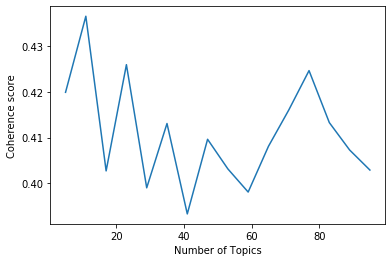

In [30]:
# Show graph
import matplotlib.pyplot as plt
%matplotlib inline
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
coherence_values

[0.4199037132995119,
 0.43653018944607785,
 0.4027268563206084,
 0.42594602388245273,
 0.39902691563176296,
 0.41308251394596474,
 0.3933238719660202,
 0.40963525025905356,
 0.40316124555673327,
 0.39810313343921544,
 0.4080975418290958,
 0.41602479579277574,
 0.42464760129271156,
 0.41328215062897017,
 0.40729868386653867,
 0.4029124591100483]